In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.core.display import HTML
HTML("<style>.container { width:100% !important; }</style>")

In [119]:
from KuhnPoker import KuhnPokerModel, KuhnPokerInfoSet, ActionNode, PASS, ADD_CHIP, Card, TensorModel, SamplingNode
from ISMCTS import Tree, Constants
from AlphaZero import NNModel, SelfPlayDataV, SelfPlayDataP

import numpy as np
import pickle
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch

In [150]:
start_ix = 0
num_model = 78

In [151]:
vmodel = []
pmodel = []

for i in range(start_ix, start_ix + num_model):
    vmodel.append(torch.load(f'model/vmodel-{i}.pt'))
    pmodel.append(torch.load(f'model/pmodel-{i}.pt'))

In [152]:
p_info_set = KuhnPokerInfoSet([0], [None, Card.JACK])
q_info_set = KuhnPokerInfoSet([0, 1], [Card.QUEEN, None])
j01_info_set = KuhnPokerInfoSet([0, 1], [None, Card.JACK])
kj01_info_set = KuhnPokerInfoSet([0, 1], [Card.KING, Card.JACK])
qj01_info_set = KuhnPokerInfoSet([0, 1], [Card.QUEEN, Card.JACK])

In [155]:
ps = []
qs = []
vs = []
vs1 = []
vs2 = []
for i in range(num_model):
    p = TensorModel(vmodel[i], pmodel[i]).eval_P(ActionNode(p_info_set))[1]
    q = TensorModel(vmodel[i], pmodel[i]).eval_P(ActionNode(q_info_set))[1]
    v, _ = TensorModel(vmodel[i], pmodel[i]).eval_V(SamplingNode(j01_info_set))
    kj_node = ActionNode(kj01_info_set)
    kj_node.spawned_tree = 1
    v1, _ = TensorModel(vmodel[i], pmodel[i]).eval_V(kj_node)
    qj_node = ActionNode(qj01_info_set)
    qj_node.spawned_tree = 1
    v2, _ = TensorModel(vmodel[i], pmodel[i]).eval_V(qj_node)
    ps.append(p)
    qs.append(q)
    vs.append(v)
    vs1.append(v1)
    vs2.append(v2)
df = pd.DataFrame({'p': ps, 'q': qs, 'v_?J[01]': vs, 'v_KJ[01]': vs1, 'v_QJ[01]': vs2})

In [156]:
df

,p,q,v_?J[01],v_KJ[01],v_QJ[01]
0,0.333333,0.333333,1.806972,1.844936,1.640843
1,0.333333,0.333333,0.927089,0.177589,0.198374
2,0.333333,0.333333,0.231201,-0.911929,-0.451373
3,0.333333,0.333333,-0.436287,-1.511092,-0.608575
4,0.333333,0.333333,-0.760035,-1.804690,-0.425826
...,...,...,...,...,...
73,0.333333,0.333333,-1.078363,-1.941663,0.056912
74,0.333333,0.333333,-1.015919,-2.017177,-0.038619
75,0.333333,0.333333,-0.575817,-1.816905,0.268442
76,0.333333,0.333333,-0.783018,-1.863145,0.213204


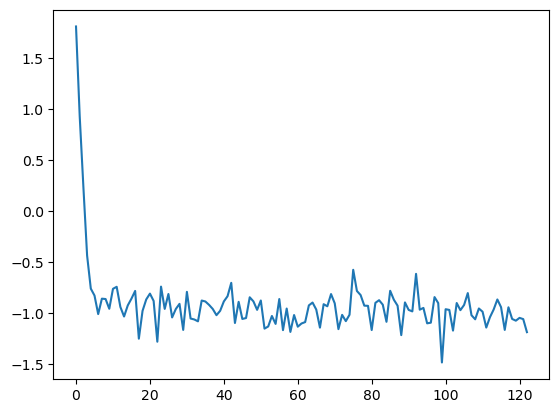

In [141]:
plt.plot(df.index, df['v_?J[01]'])

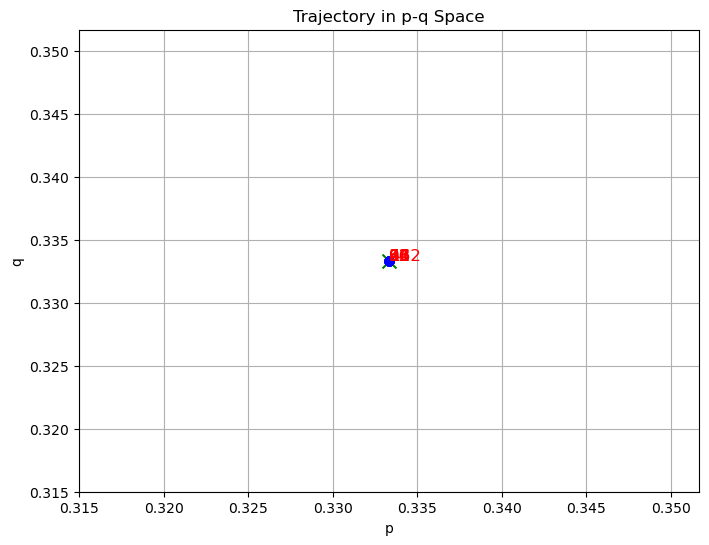

In [133]:
data = df

plt.figure(figsize=(8, 6)) 
plt.plot(data['p'], data['q'], marker='o', linestyle='-', color='b')
plt.title('Trajectory in p-q Space') 
plt.xlabel('p')  
plt.ylabel('q') 
plt.grid(True) 

# Annotate every 10th point with its order number
for i, (p, q) in enumerate(zip(data['p'], data['q'])):
    if i % 16 == 0: 
        plt.text(p, q, str(i), color="red", fontsize=12)
        
plt.scatter([1/3], [1/3], color='green', s=100, marker='x', label='Target (1/3, 1/3)')

plt.show()

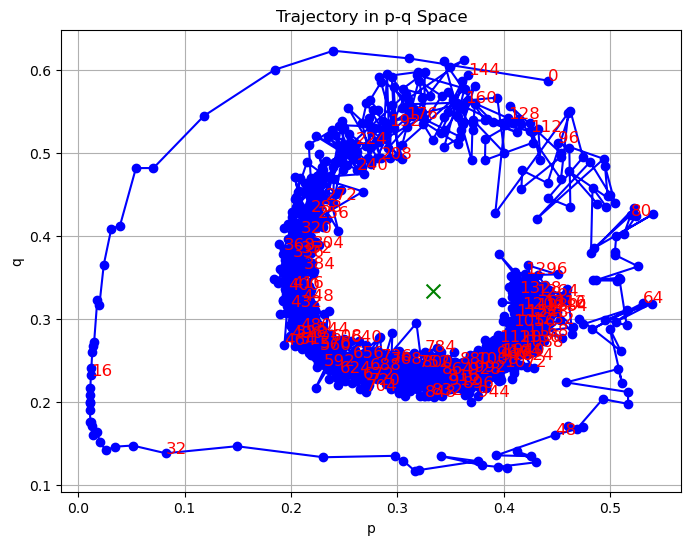

In [97]:
data = df

plt.figure(figsize=(8, 6)) 
plt.plot(data['p'], data['q'], marker='o', linestyle='-', color='b')
plt.title('Trajectory in p-q Space') 
plt.xlabel('p')  
plt.ylabel('q') 
plt.grid(True) 

# Annotate every 10th point with its order number
for i, (p, q) in enumerate(zip(data['p'], data['q'])):
    if i % 16 == 0: 
        plt.text(p, q, str(i), color="red", fontsize=12)
        
plt.scatter([1/3], [1/3], color='green', s=100, marker='x', label='Target (1/3, 1/3)')

plt.show()

In [112]:
with open('self_play_games/self_play_games.pkl', 'rb') as f:
    games = pickle.load(f)

In [ ]:
games

In [14]:
data = SelfPlayDataV(games)

In [29]:
subset = []
for g in games:
    if g.info_set.action_history == [0, 1] and g.info_set.cards ==[Card.QUEEN, None]:
        subset.append(g)
df = pd.DataFrame(subset)
df['prob_1'] = df['action_dist'].apply(lambda x: x[1])

In [53]:
pd.DataFrame(data)

,p,q
0,0.441448,0.586929
1,0.310708,0.613656
2,0.239817,0.622888
3,0.184654,0.599999
4,0.118252,0.544457
...,...,...
645,0.253218,0.247692
646,0.255996,0.236919
647,0.270091,0.251956
648,0.270182,0.224615


In [40]:
df['prob_1'].describe()

count    10837.000000
mean         0.290022
std          0.268654
min          0.020000
25%          0.090000
50%          0.140000
75%          0.520000
max          0.870000
Name: prob_1, dtype: float64

In [36]:
df['outcome'].value_counts()

-1.0    5449
 2.0    5388
Name: outcome, dtype: int64

In [59]:
policy_data = pd.DataFrame(games)

In [60]:
policy_data

,info_set,action_dist,action,game_id,gen_id,outcome
0,"[0], cards=JQ","{0: 0.99, 1: 0.01}",1.0,0,0,2.0
1,"[01], cards=JQ","{0: 0.98, 1: 0.02}",1.0,0,0,-2.0
2,"[011], cards=JQ",None,NaN,0,0,2.0
3,"[0], cards=JQ","{0: 0.99, 1: 0.01}",1.0,1,0,1.0
4,"[01], cards=JQ","{0: 0.98, 1: 0.02}",0.0,1,0,-1.0
...,...,...,...,...,...,...
327686,"[0], cards=QJ","{0: 0.65, 1: 0.35}",1.0,254,511,-2.0
327687,"[01], cards=QJ","{0: 0.92, 1: 0.08}",1.0,254,511,2.0
327688,"[011], cards=QJ",None,NaN,254,511,-2.0
327689,"[0], cards=JQ","{0: 0.96, 1: 0.04}",0.0,255,511,1.0
